In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = yf.download('AAPL', start='2022-01-01', end='2023-09-05')['Adj Close']
S0 = data[-1]  # The latest available price

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Initialize Parameters
K = 100
K1, K2, K3 = 90, 100, 110  # For Butterfly Spread
T = 1.0
r = 0.05
sigma = 0.2
M = 100
dt = T / M
I = 10000

In [6]:
# Monte Carlo Simulation
np.random.seed(0)
Z = np.random.standard_normal((M + 1, I))
S = np.zeros((M + 1, I))
S[0] = S0
for t in range(1, M + 1):
    S[t] = S[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[t])

In [7]:
from numpy.polynomial.polynomial import Polynomial

# American Option Pricing
def american_option(S, K, r, dt):
    payoffs = np.maximum(S[-1] - K, 0)
    for t in range(len(S) - 2, 0, -1):
        discount_factor = np.exp(-r * dt)
        payoffs *= discount_factor
        in_the_money = S[t] > K
        x = S[t][in_the_money]
        y = payoffs[in_the_money]
        poly = Polynomial.fit(x, y, 2)
        continuation_value = poly(x)
        exercise_value = S[t][in_the_money] - K
        if exercise_value.shape == continuation_value.shape:
            payoffs[in_the_money] = np.where(exercise_value > continuation_value, exercise_value, payoffs[in_the_money])
    return np.exp(-r * dt) * np.mean(payoffs)


print(f"American Option Value: {american_option(S, K, r, dt)}")

American Option Value: 94.8642415410659


In [8]:
# Greeks - Delta and Vega
C0 = american_option(S, K, r, dt)
delta = (C0 - american_option(S, K + 1, r, dt)) / 1
vega = (C0 - american_option(S, K, r, dt + 0.01)) / 0.01

print(f"Delta: {delta}")

Delta: 0.9477390796385521


# 1. Stock Price Paths

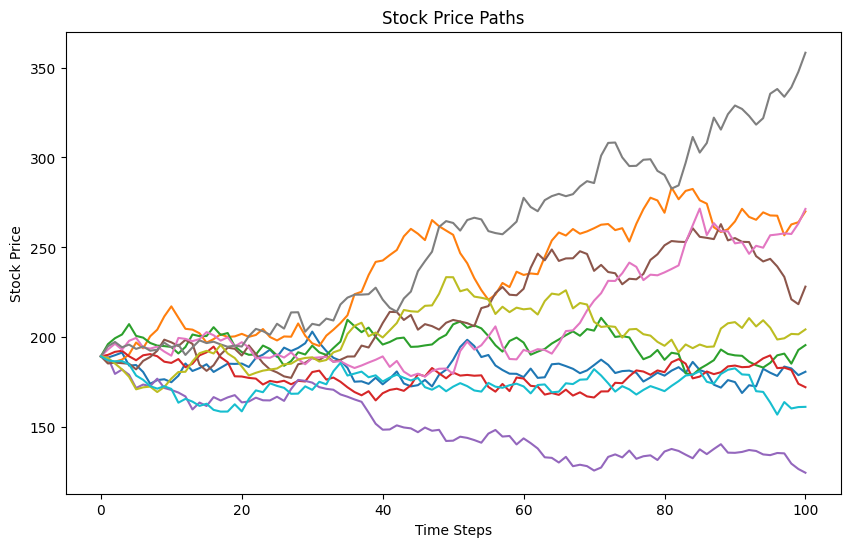

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(S[:, :10])
plt.title('Stock Price Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

# 2. Payoff at maturity for the American Option

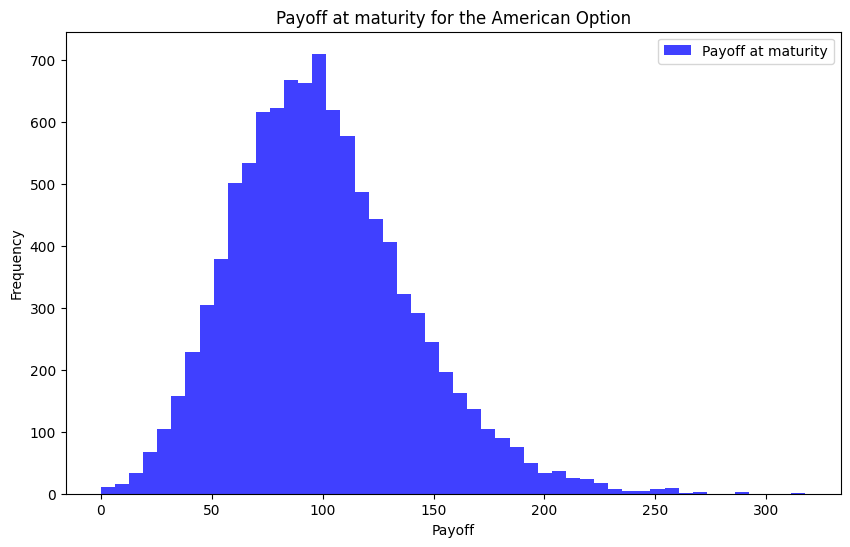

In [10]:
payoffs = np.maximum(S[-1] - K, 0)
plt.figure(figsize=(10, 6))
plt.hist(payoffs, bins=50, alpha=0.75, color='b', label='Payoff at maturity')
plt.title('Payoff at maturity for the American Option')
plt.xlabel('Payoff')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

# 3. Histogram of Monte Carlo simulated end-of-period stock prices

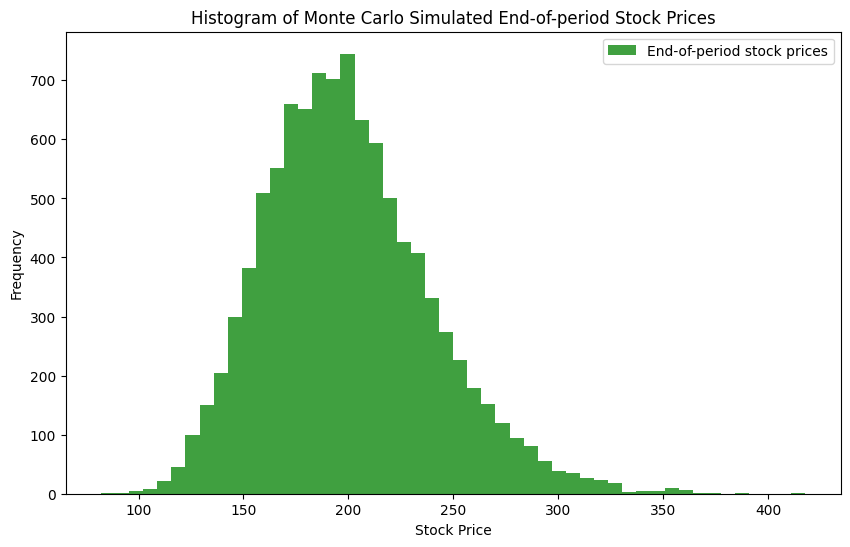

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(S[-1], bins=50, alpha=0.75, color='g', label='End-of-period stock prices')
plt.title('Histogram of Monte Carlo Simulated End-of-period Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()


In [13]:
import dash
from dash import dcc
from dash import html
import plotly.graph_objs as go
import numpy as np

# Your existing code to generate S, K, and other parameters
# ...

app = dash.Dash(__name__)

# Define layout
app.layout = html.Div([
    html.H1("Option Pricing with Monte Carlo Simulation"),
    
    dcc.Graph(
        id='stock-price-paths',
        figure={
            'data': [go.Scatter(y=S[:, i], mode='lines') for i in range(10)],
            'layout': go.Layout(title='Stock Price Paths',
                                xaxis={'title': 'Time Steps'},
                                yaxis={'title': 'Stock Price'})
        }
    ),
    
    dcc.Graph(
        id='payoff-at-maturity',
        figure={
            'data': [go.Histogram(x=np.maximum(S[-1] - K, 0))],
            'layout': go.Layout(title='Payoff at maturity for the American Option',
                                xaxis={'title': 'Payoff'},
                                yaxis={'title': 'Frequency'})
        }
    ),
    
    dcc.Graph(
        id='end-of-period-stock-prices',
        figure={
            'data': [go.Histogram(x=S[-1])],
            'layout': go.Layout(title='Histogram of Monte Carlo Simulated End-of-period Stock Prices',
                                xaxis={'title': 'Stock Price'},
                                yaxis={'title': 'Frequency'})
        }
    ),
    
    # dcc.Graph(
    #     id='delta-across-range',
    #     figure={
    #         # You may want to pre-calculate the delta_values to speed up the app
    #         'data': [go.Scatter(x=np.linspace(0.5 * S0, 1.5 * S0, 100), y=delta_values, mode='lines')],
    #         'layout': go.Layout(title='Delta across a range of stock prices',
    #                             xaxis={'title': 'Stock Price'},
    #                             yaxis={'title': 'Delta'})
    #     }
    # )
])

if __name__ == '__main__':
    app.run_server(debug=True)
